<a href="https://colab.research.google.com/github/doublea1186/CIS522/blob/main/Non_deep_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
#@title Imports and installs
!pip install transformers

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd 
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
import albumentations as alb
from tqdm.autonotebook import tqdm, trange
import itertools
import seaborn as sns
from numpy import savetxt, loadtxt
import torchvision.models as models
from google.colab import files

In [ ]:
#@title Download dataset (takes 20 minutes)

! pip install kaggle
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c h-and-m-personalized-fashion-recommendations
! unzip -q h-and-m-personalized-fashion-recommendations.zip -d .

In [ ]:
#@title Data configs
class Config:
  base = '' # change to whereever the data is stored
  debug = False

  # we want batch size to be as big as possible for contrastive loss
  # OpenAI uses 32768 but we can only use 128 due to RAM constraints 
  batch_size = 128

  num_workers = 2
  head_lr = 1e-3
  image_encoder_lr = 1e-4
  text_encoder_lr = 1e-5

  # weight decay is .2 in CLIP Paper
  weight_decay = 0.2

  # we use a different LR, namely decrease on Plateau 
  # Decrease LR after 1 epoch with no improvement 
  patience = 1
  factor = 0.8

  # CLIP paper did 32 epochs
  # because of our compute we can only realistically do 10 epochs 
  # takes about 20 minutes per epoch using AWS EC2 p3.2xlarge instance
  # total runtime of about 4 hours to train the model 
  epochs = 8
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


  model_name = 'resnet50'
  image_embedding = 2048
  base_image_embedding = 64
  resnet18_embed = 512

  # original text encoder was transformer
  text_encoder_model = "distilbert-base-uncased"
  text_embedding = 768
  base_text_embedding = 300
  text_tokenizer = "distilbert-base-uncased"
  max_length = 50

  pretrained = True # for both image encoder and text encoder
  trainable = True # for both image encoder and text encoder
  temperature = 1.0

  # CLIP used 224, have to use 112 for computational advantages
  image_size = 112

  # for projection head; used for both image and text encoders
  num_projection_layers = 1
  projection_dim = 256 
  dropout = 0.3

## Loading and Feature Engineering Text Data for Clothing

In [ ]:
articles = pd.read_csv(Config.base + 'articles.csv')
articles = articles.set_index(['article_id'])
articles.loc[articles.index == 108775015, 'detail_desc']

article_id
108775015    Jersey top with narrow shoulder straps.
Name: detail_desc, dtype: object

In [ ]:
#Extract natural language columns
articles_nlp = articles[['prod_name','product_type_name','product_group_name','graphical_appearance_name','colour_group_name','perceived_colour_value_name','perceived_colour_master_name','department_name','index_name','index_group_name','section_name','garment_group_name', 'detail_desc']]

In [ ]:
index_group_to_nlp = {'Ladieswear':"women", 'Baby/Children':'children', 'Menswear':'men', 'Sport':'sport', 'Divided':'all genders'}

In [ ]:
articles_nlp['index_group_name']=articles_nlp['index_group_name'].apply(lambda x: index_group_to_nlp[x])

In [ ]:
desc_format = "A picture of a {0}, a {12} It is a {1}, which is a {2} for {9}. It is {6} with a {5} pattern."
articles_nlp['long_description'] = [desc_format.format(*r) for r in articles_nlp.values.tolist()]

In [ ]:
articles_nlp["long_description"][108775015]

'A picture of a Strap top, a Jersey top with narrow shoulder straps. It is a Vest top, which is a Garment Upper body for women. It is Black with a Dark pattern.'

In [ ]:
articles["long_description"] = articles_nlp["long_description"]

# Base Non Deep Model

## Custom Dataset Class and DataLoader Object


In [ ]:
# Helper functions for creating data loader object 
def find_classes(directory):
  """Find the class folders in a dataset structured as follows::

          directory/
          ├── class_x
          │   ├── xxx.ext
          │   ├── xxy.ext
          │   └── ...
          │       └── xxz.ext
          └── class_y
              ├── 123.ext
              ├── nsdf3.ext
              └── ...
              └── asd932_.ext

      This method can be overridden to only consider
      a subset of classes, or to adapt to a different dataset directory structure.

      Args:
          directory(str): Root directory path, corresponding to ``self.root``

      Raises:
          FileNotFoundError: If ``dir`` has no class folders.

      Returns:
          (Tuple[List[str], Dict[str, int]]): List of all classes and dictionary mapping each class to an index.
      """
  directory = os.path.expanduser(directory)
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  if not classes:
      raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx

def make_dataset(directory):
  # loads articles dataframe to get image descriptions from 
  articles = pd.read_csv(Config.base + 'articles.csv')

  # sets the primary index as the article id
  articles = articles.set_index(['article_id'])
  articles["long_description"] = articles_nlp["long_description"]
  extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']
  images, captions = [], []
  _, class_to_idx = find_classes(directory)

  for target_class in sorted(class_to_idx.keys()):
    class_index = class_to_idx[target_class]
    target_dir = os.path.join(directory, target_class)
    if not os.path.isdir(target_dir):
      continue
    for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
      for fname in sorted(fnames):
        # get image path
        path = os.path.join(root, fname)

        # get text article id
        article_id = fname.split('.')[0]
        description = articles.loc[articles.index == int(article_id), "long_description"].values[0]

        # only add data if there exists a description i.e not empty
        if type(description) == str:
          captions.append(description)
          images.append(path)

  return images, captions 

# Resizes and normalizes the images
def get_transforms():
  return alb.Compose([
       alb.Resize(Config.image_size, Config.image_size, always_apply=True),
       alb.Normalize(max_pixel_value=255.0, always_apply=True),
      ])

In [ ]:
class BaseHMDataset(torch.utils.data.Dataset):
  def __init__(self, root, tokenizer, transforms):
    """
    There is a one to one correspondance between images and text.
    """
    self.images, self.captions = make_dataset(root)
    self.text_tokens = tokenizer(list(self.captions), padding=True, truncation=True, max_length=Config.max_length) 
    self.transforms = transforms 

  def __getitem__(self, index):
    # converts the input_id and attention_mask of the token output into tensors
    item = {
        key: torch.tensor(values[index])
        for key, values in self.text_tokens.items()
        }

    img_path = self.images[index]
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      
    image = self.transforms(image=image)['image']
    item['image'] = torch.tensor(image).permute(2, 0, 1).float()
    item['caption'] = self.captions[index]

    return item 

  def __len__(self):
    return len(self.images)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(Config.text_tokenizer)
transforms = get_transforms()
baseline_dataset = BaseHMDataset('/content/images/',
                                 tokenizer=tokenizer,
                                 transforms=transforms)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
resnet = models.resnet18(pretrained=True)
modules = list(resnet.children())[:-1]
img_encoder = torch.nn.Sequential(*modules)
for p in img_encoder.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
class TextEncoder(nn.Module):
  def __init__(self, model_name=Config.text_encoder_model):
    super().__init__()
    self.model = DistilBertModel.from_pretrained(model_name)
    for p in self.model.parameters():
      p.requires_grad = False
    
    # use CLS token hidden representation as sentence embedding
    self.target_token = 0

  def forward(self, ids, mask):
    x = self.model(input_ids=ids, attention_mask=mask)
    last = x.last_hidden_state

    # DistilBert output hidden representation is vector of size 768
    return last[:, self.target_token, :]

In [ ]:
text_encoder = TextEncoder()

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def contrastive_loss(text_embedding, image_embedding):
  logit = (text_embedding @ torch.transpose(image_embedding,0,1)) / Config.temperature
  text_similarity = text_embedding @ text_embedding.T
  image_similarity = image_embedding @ image_embedding.T

  # get targets by averaging text and image similarity
  targets = F.softmax(
      (image_similarity + text_similarity) / 2 * Config.temperature,
      dim = 1
  )

  text_loss = cross_entropy(logit, targets)
  image_loss = cross_entropy(logit.T, targets.T)

  avg_loss = (text_loss + image_loss) / 2.0
  return avg_loss.mean()


def cross_entropy(pred, labels, reduction='none'):
  '''
  Define custom function since there is a potential for multiple captions per image
  '''

  log_softmax = nn.LogSoftmax(dim=-1)
  loss = (-labels * log_softmax(pred)).sum(1)

  if reduction == 'mean':
    loss = loss.mean()
  
  return loss 


## Model

In [ ]:
class BaseModel(nn.Module):
  def __init__(self, img_encoder, text_encoder, text_embed_dim, img_embed_dim, project_dim=Config.projection_dim):
    super().__init__()
    
    self.batch_size = Config.batch_size
    self.image_encoder = img_encoder
    self.text_encoder = text_encoder

    self.image_projection = nn.Linear(img_embed_dim, project_dim)
    self.text_projection = nn.Linear(text_embed_dim, project_dim)
  
  def forward(self, batch):
    image_features = self.image_encoder(batch['image']).squeeze()
    text_features = self.text_encoder(ids=batch['input_ids'], mask=batch['attention_mask'])
    
    # project into same space
    image_embeddings = self.image_projection(image_features)
    text_embeddings = self.text_projection(text_features)

    #calculate loss
    return contrastive_loss(image_embeddings, text_embeddings)

## Training

In [ ]:
#@title Make dataloaders
# split dataset

train_size = int(0.8 * len(baseline_dataset))
valid_size = len(baseline_dataset) - train_size

# split full dataset into a training/test set with an 80/20 split
train_dataset, valid_dataset = torch.utils.data.random_split(
    baseline_dataset, [train_size, valid_size]
    )

indices = torch.randperm(len(train_dataset))
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dataset, indices),
    batch_size=Config.batch_size,
    num_workers=Config.num_workers,
)

indices = torch.randperm(len(valid_dataset))
valid_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(valid_dataset, indices),
    batch_size=Config.batch_size,
    num_workers=Config.num_workers,
)

In [ ]:
#@title Loss tracker object
class LossTracker:
  def __init__(self, num_batches):
    self.losses = []
    self.batch_count = 0
    self.running_loss = 0
    self.losses_per_epoch = [] # average loss per epoch
    self.num_batches = num_batches # never updated

  # call after every batch
  def update(self, new_loss):
    self.batch_count += 1
    self.losses.append(new_loss)
    self.running_loss += new_loss

  # call after every epoch
  def update_epoch(self):
    self.losses_per_epoch.append(self.running_loss / self.num_batches)
    self.running_loss = 0

# getting the learning rate
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group["lr"]

In [ ]:
model = BaseModel(img_encoder, text_encoder, Config.text_embedding, Config.resnet18_embed).to(Config.device)
params = [
          {"params": itertools.chain(model.image_projection.parameters(), model.text_projection.parameters()),
           "lr": 1e-3, "betas": (0.9, 0.98), "eps": 1e-6, "weight_decay": 1e-3}
          ]
EPOCHS = 5
optimizer = torch.optim.AdamW(params)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-4)

In [ ]:
def train_epoch(model, train_loader, optimizer, train_losses):
  tqdm_object = tqdm(train_loader, total=len(train_loader))
  for batch in tqdm_object:
    batch = {k: v.to(Config.device) for k, v in batch.items() if k != "caption"}
    loss = model(batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_losses.update(loss.item())
    tqdm_object.set_postfix(train_loss=train_losses.losses[-1], lr=get_lr(optimizer))

  train_losses.update_epoch()
  return train_losses

def val_epoch(model, valid_loader, val_losses):
  tqdm_object = tqdm(valid_loader, total=len(valid_loader))
  with torch.no_grad():
    for batch in tqdm_object:
      batch = {k: v.to(Config.device) for k, v in batch.items() if k != "caption"}
      loss = model(batch)
      val_losses.update(loss.item())
      tqdm_object.set_postfix(valid_loss=val_losses.losses[-1])
  
  val_losses.update_epoch()
  return val_losses

In [ ]:
def train(model, num_epochs, train_losses, val_losses):
  min_loss = float('inf')

  for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1} \n")
    train_loss = train_epoch(model, train_loader, optimizer, train_losses).losses_per_epoch[-1]
    print(f"Train Loss: {train_loss}")

    model.eval()
    val_loss = val_epoch(model, valid_loader, val_losses).losses_per_epoch[-1]

    if val_loss < min_loss:
      torch.save(model.state_dict(), "best_base.pt")
      min_loss = val_loss
  
    scheduler.step()
    print(f"Validation Loss: {val_loss}")
  
  return train_losses, val_losses

In [ ]:
train_losses = LossTracker(len(train_loader))
val_losses = LossTracker(len(valid_loader))
train(model, EPOCHS, train_losses, val_losses)

Epoch: 1 



  0%|          | 0/657 [00:00<?, ?it/s]

Train Loss: 4.283326257490858


  0%|          | 0/165 [00:00<?, ?it/s]

Validation Loss: 3.584662203355269
Epoch: 2 



  0%|          | 0/657 [00:00<?, ?it/s]

Train Loss: 3.27545560948562


  0%|          | 0/165 [00:00<?, ?it/s]

Validation Loss: 3.203283195062117
Epoch: 3 



  0%|          | 0/657 [00:00<?, ?it/s]

Train Loss: 2.8932186250817287


  0%|          | 0/165 [00:00<?, ?it/s]

Validation Loss: 3.0693834283135155
Epoch: 4 



  0%|          | 0/657 [00:00<?, ?it/s]

Train Loss: 2.60494005262761


  0%|          | 0/165 [00:00<?, ?it/s]

Validation Loss: 2.7919908783652567
Epoch: 5 



  0%|          | 0/657 [00:00<?, ?it/s]

Train Loss: 2.3908316323383394


  0%|          | 0/165 [00:00<?, ?it/s]

Validation Loss: 2.6522101358933883


(<__main__.LossTracker at 0x7f64e0e9d990>,
 <__main__.LossTracker at 0x7f64e0edde10>)

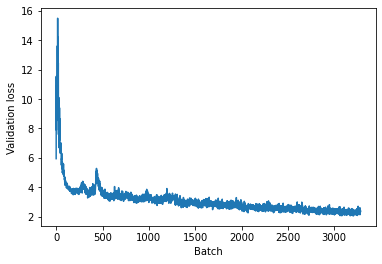

In [ ]:
plt.plot(train_losses.losses)
plt.xlabel('Batch')
plt.ylabel('Validation loss')
plt.show()

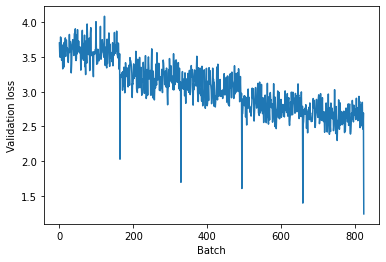

In [ ]:
plt.plot(val_losses.losses)
plt.xlabel('Batch')
plt.ylabel('Validation loss')
plt.show()

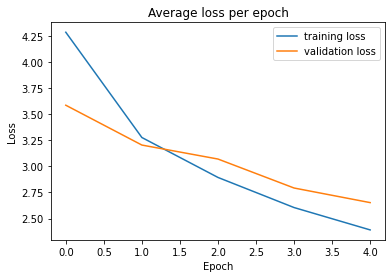

In [ ]:
x = range(EPOCHS)
plt.plot(x, train_losses.losses_per_epoch, label='training loss')
plt.plot(x, val_losses.losses_per_epoch, label='validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average loss per epoch')
plt.show()